# Test our First Implementation of the Model

In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

from IPython.display import display

import sys
import copy 
from time import time

import numpy as np 
import matplotlib.pyplot as plt

from astropy.table import Table, Column

from halotools.sim_manager import CachedHaloCatalog
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import delta_sigma
from halotools.mock_observables import tpcf
from halotools.mock_observables import delta_sigma_from_precomputed_pairs
from halotools.utils import crossmatch

# UniverseMachine Python IO
from umachine_pyio.load_mock import load_mock_from_binaries, value_added_mock

from stellar_mass_function import compute_smf, bootstrap_smf
from model_predictions import total_stellar_mass_including_satellites, precompute_lensing_pairs
from full_mass_profile_model import sm_profile_from_mhalo

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

In [2]:
# Bolshoi P Om=0.30711
# Planck13 Om=0.307

# from astropy.cosmology import Planck13 as cosmo
# print(cosmo.H(0))

# Setup Cosmology
from astropy.cosmology import FlatLambdaCDM

h = 0.7
cosmo = FlatLambdaCDM(H0=(h * 100), 
                      Om0=0.307)

In [3]:
um_temp = load_mock_from_binaries(root_dirname=root_dirname,
                                  subvolumes=subvolumes)
um_temp = value_added_mock(um_temp, lbox)
print(um_temp.colnames)

NameError: name 'root_dirname' is not defined

Total runtime = 18.84 seconds
['obs_sfr', 'icl', 'upid', 'sfr', 'halo_id', 'mpeak', 'y', 'sm', 'mvir', 'x', 'z', 'obs_sm', 'halo_hostid', 'host_halo_mvir', 'mask_central', 'mtot_galaxy', 'mstar_mhalo', 'logms_gal', 'logms_icl', 'logms_tot', 'logms_halo', 'logmh_vir', 'logmh_peak', 'mhalo_host', 'logmh_host']


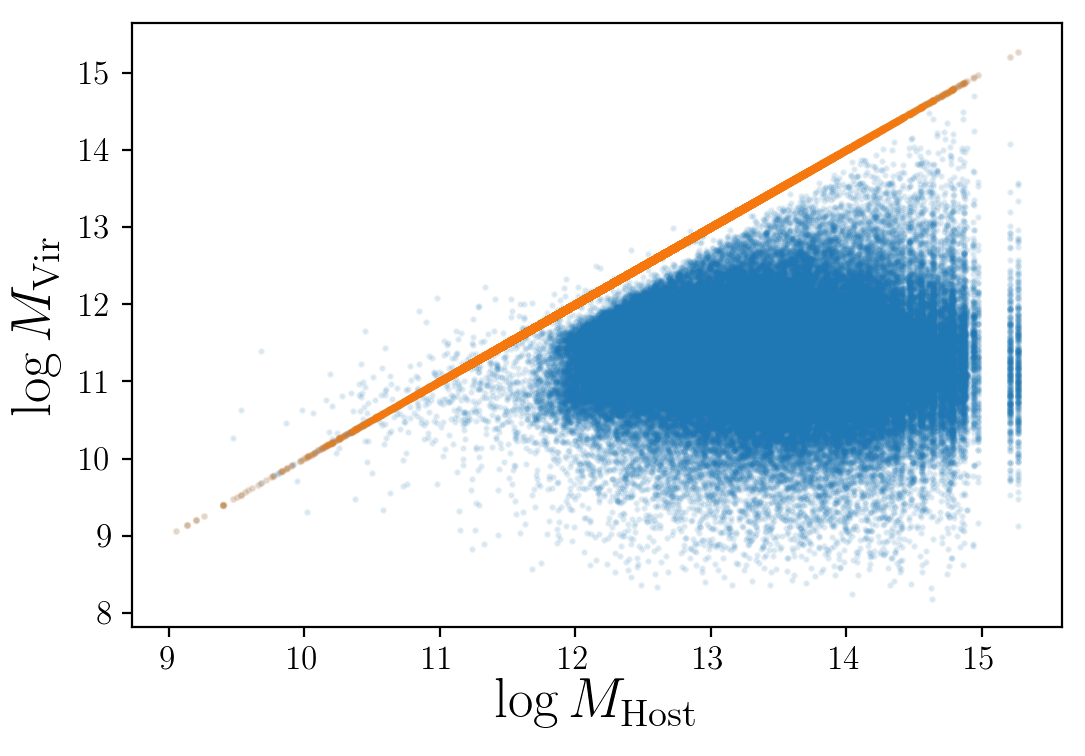

In [3]:
# Read in the Halo Data
# get Mhalo / frac_sm100_by_smtot / frac_sm10_by_sm100
# Get x,y,z coordinates as well for lensing

# Size of the simulation box
lbox = 250.0  # Mpc

#  Select which data you wish to be loaded into memory
galprops = list(('sm', 'sfr', 'obs_sm', 'obs_sfr', 'icl', 
                 'mvir', 'halo_id', 'upid', 'mpeak', 
                 'x','y','z'))

# UM directory
#root_dirname = "/Users/alexie/Work/HSC/UniverseMachine/Data"
root_dirname = "Data/a_1.002310"

# All 144 subvolumes to load the whole mock
subvolumes = np.arange(144)
um_mock = load_mock_from_binaries(galprops=galprops, 
                                  root_dirname=root_dirname,
                                  subvolumes=subvolumes)
mock = value_added_mock(um_mock, lbox)

# Sort the catalog based on the host halo ID
mock.sort('halo_hostid')

# Make a mask for central galaxies
mask_central = mock['upid'] == -1
mock.add_column(Column(data=mask_central, name='mask_central'))

# Add a column as the BCG+ICL mass
mock.add_column(Column(data=mock['sm'] + mock['icl'], name='mtot_galaxy'))

# Total stellar masses within a halo, including the satellites
mstar_mhalo = total_stellar_mass_including_satellites(mock, 'mtot_galaxy')
mock.add_column(Column(data=mstar_mhalo, name='mstar_mhalo'))

# Add log10(Mass)
## Stellar mass
mock.add_column(Column(data=np.log10(mock['sm']), name='logms_gal'))
mock.add_column(Column(data=np.log10(mock['icl']), name='logms_icl'))
mock.add_column(Column(data=np.log10(mock['mtot_galaxy']), name='logms_tot'))
mock.add_column(Column(data=np.log10(mock['mstar_mhalo']), name='logms_halo'))
## Halo mass
mock.add_column(Column(data=np.log10(mock['mvir']), name='logmh_vir'))
mock.add_column(Column(data=np.log10(mock['mpeak']), name='logmh_peak'))


# The 'mvir' in the mock catalog is not the halo mass of parent halo
# Get the host halo mass of each galaxy 
idxA, idxB = crossmatch(mock['halo_hostid'], mock['halo_id'])

mhalo_host = copy.deepcopy(mock['mvir'].data)
mhalo_host[idxA] = mock[idxB]['mvir']

logmh_host = copy.deepcopy(mock['logmh_vir'].data)
logmh_host[idxA] = mock[idxB]['logmh_vir']

# Notice: There are ~500 satellites without host halo
#         And there are ~4000 satellits without matched centrals 
#         Right now, we just use their 'mvir' as host halo mass

plt.scatter(logmh_host, mock['logmh_vir'], s=2, alpha=0.1);
plt.scatter(logmh_host[mask_central], mock['logmh_vir'][mask_central], 
            s=3, alpha=0.1);
plt.xlabel(r'$\log M_{\mathrm{Host}}$', size=20); 
plt.ylabel(r'$\log M_{\mathrm{Vir}}$', size=20); 

# Add a new column
mock.add_column(Column(data=mhalo_host, name='mhalo_host'))
mock.add_column(Column(data=logmh_host, name='logmh_host'))


print(mock.colnames)

# Save the mock catalog now 
## This is just for Song Huang, to save time for the followin test
mock.write('Data/UM_bolshoi_mock_value_added.fits', format='fits', 
           overwrite=True)

# There are 17074 galaxies with peak halo mass > 10^12 Msun
# SMHM : logMs_tot = 0.8314 x logMh_vir + 0.5606


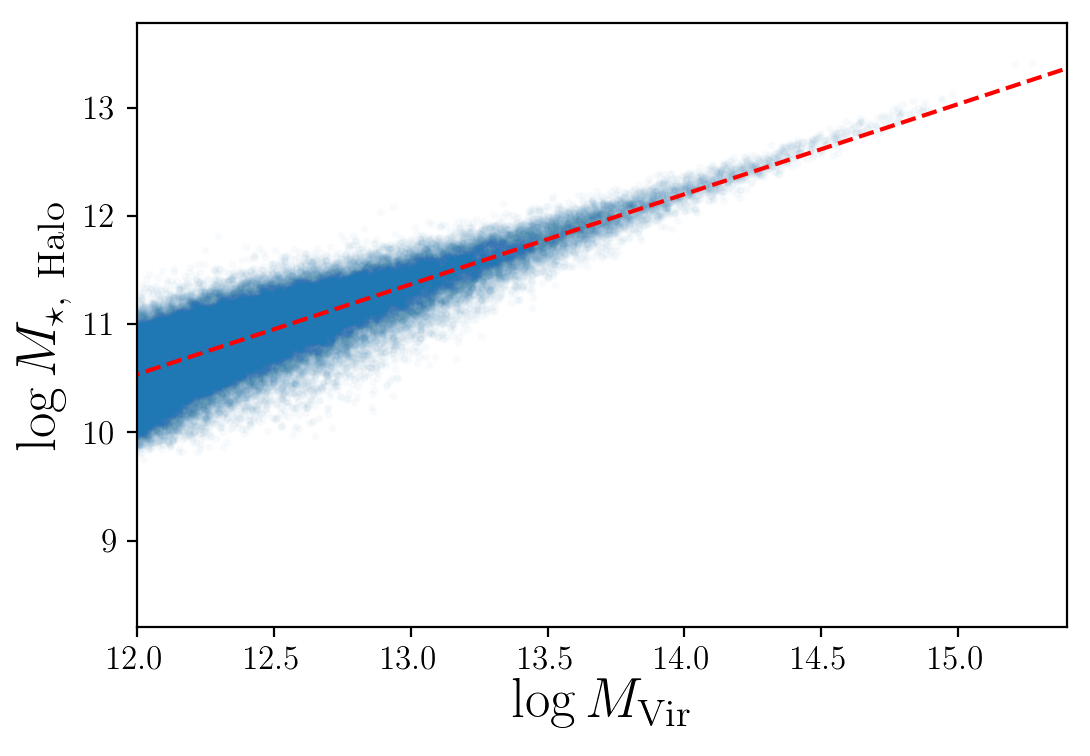

In [5]:
# Fit Mhalo-Mstar log-log linear relation
log_mhalo_central = mock['logmh_vir'][mask_central]
log_mstar_mhalo_central = mock['logms_halo'][mask_central]

# Only fit for halos more massive than 10^12 Msun
mask_massive = (mock['logmh_peak'][mask_central] > 12.8)
print("# There are %d galaxies with peak halo mass > 10^12 Msun" % np.sum(mask_massive))

# Using Numpy Polyfit is much faster
## Log-Log Linear relation
smhm_a, smhm_b = np.polyfit(log_mhalo_central[mask_massive], 
                            log_mstar_mhalo_central[mask_massive], 
                            1)
print("# SMHM : logMs_tot = %6.4f x logMh_vir + %6.4f" % (smhm_a, smhm_b))

# Visualize the best-fit relation
mh_arr = np.linspace(9.5, 15.6, 50)
plt.scatter(log_mhalo_central, log_mstar_mhalo_central, 
            s=4, alpha=0.02, rasterized=True);
plt.plot(mh_arr, (smhm_a * mh_arr + smhm_b), linestyle='--', 
         c='r');
plt.xlabel(r'$\log M_{\mathrm{Vir}}$', size=20); 
plt.ylabel(r'$\log M_{\star,\ \mathrm{Halo}}$', size=20);
plt.xlim(12.0, 15.4);

[11.713149220206153, 12.093085083261641, 12.294488727141502, 12.492893674816957, 12.692793112720869, 12.893708207011574, 13.091102380222088, 13.291072315953834, 13.491622556009599, 13.691319930201315, 13.889727499523401, 14.090367226186553, 14.287938976428364, 14.490762736071757, 14.69859920914284, 14.876137230380737]
[0.24557231851419284, 0.24278079121462762, 0.22953123195063366, 0.22359287980087628, 0.21886069805551112, 0.20378170805187165, 0.18559959639689244, 0.15888116627559257, 0.14005099535551604, 0.11894530362617153, 0.10507755190174009, 0.092467751605988413, 0.085328182228976687, 0.074243977746917655, 0.072784883333463279, 0.057098015018163341]
# Mh-sigMs : sigMs = -0.0690 x logMh_vir + 1.0762


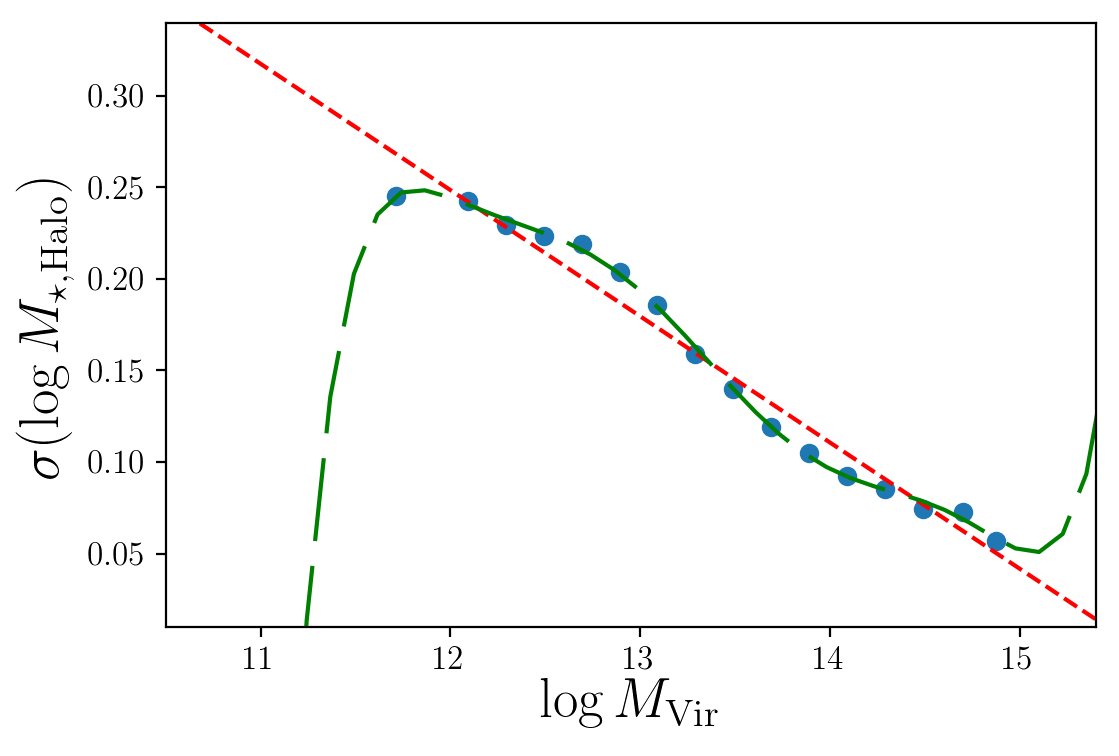

In [9]:
# Functional form for scatter in M*_total versus Mhalo
# !! Only for central galaxies

# First, estimate the running scatters of logMs_tot
mhalo_bin = np.linspace(12.0, 15.0, 16)
#mhalo_bin = np.append([10.5, 11.0, 11.5], mhalo_bin)

# This trick is faster than loop! 
idx_mhalo = np.digitize(log_mhalo_central, mhalo_bin)

mhalo_center = [np.nanmean(log_mhalo_central[idx_mhalo == k]) 
                for k in range(len(mhalo_bin))]
sigma_mstar = [np.nanstd(log_mstar_mhalo_central[idx_mhalo == k]) 
               for k in range(len(mhalo_bin))]

# Fit logMhalo - sigma_Ms_tot relation
## Log-Log Linear relation
sigms_a, sigms_b = np.polyfit(mhalo_center, sigma_mstar, 1)
print("# Mh-sigMs : sigMs = %6.4f x logMh_vir + %6.4f" % (sigms_a, sigms_b))

# Higher order polynomial
sigms_poly = np.poly1d(np.polyfit(mhalo_center, sigma_mstar, 7 ))

# Visualize the results
plt.scatter(mhalo_center, sigma_mstar)
plt.plot(mh_arr, (sigms_a * mh_arr + sigms_b), 
         c='r', linestyle='--')
plt.plot(mh_arr, sigms_poly(mh_arr), 
         c='g', linestyle='--', dashes=(20, 6))

plt.xlabel(r'$\log M_{\mathrm{Vir}}$', size=20); 
plt.ylabel(r'$\sigma(\log M_{\star, \mathrm{Halo}})$', size=20);
plt.xlim(10.5, 15.4);
plt.ylim(0.01, 0.34);

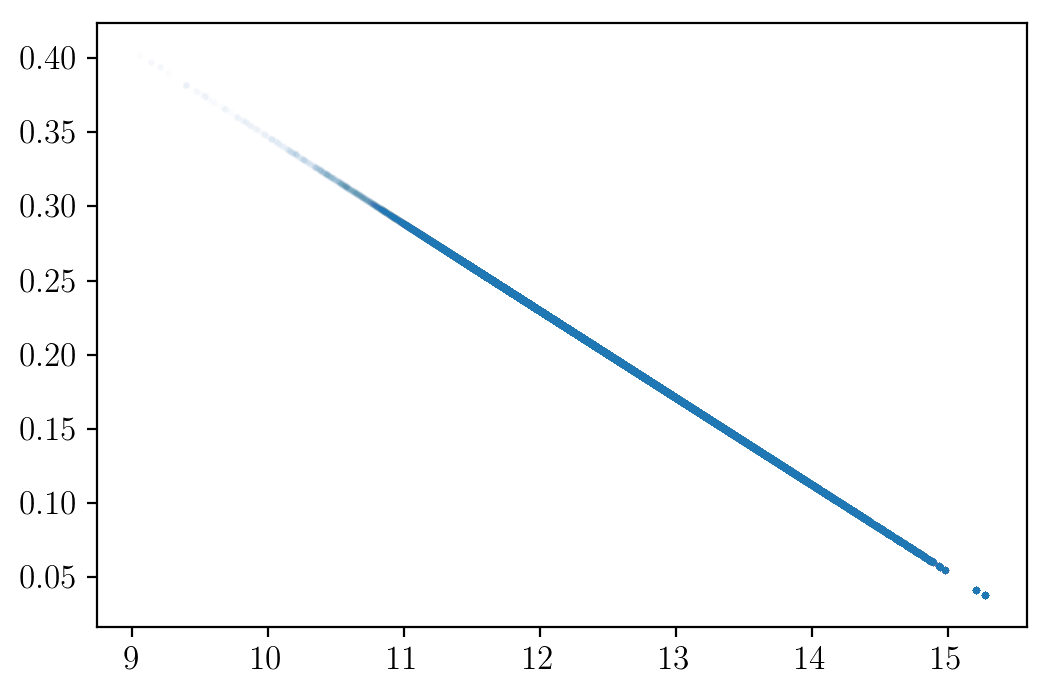

In [7]:
# Estimate the scatter based on the Mhalo-Sigma_Mstar relation
sigms_logmh_host = logmh_host * sigms_a + sigms_b

# Add a new column
mock.add_column(Column(data=sigms_logmh_host, name='sigms_logmh_host'))

plt.scatter(logmh_host, sigms_logmh_host, s=3, alpha=0.01);

## Test sm_profile_from_mhalo

In [9]:
# M100 cut 
## !! To make sure there are enough number galaxies in each M100 bins
mask_mass_cut = ((mock['logms_tot'] > 9.75) & 
                 (mock['logms_tot'] < 12.45))

# Make the model
mhalo = mock['mhalo_host']
random_scatter_in_dex = mock['sigms_logmh_host']

# Here we are using the UM results as "Data"
## Using the galaxy stellar mass as "M10" in UM
log_m10_data = mock['logms_gal']
## Using the galaxy+ICL stellar mass as "M100" in UM
log_m100_data = mock['logms_tot']

# Log M100 bin size
## Binning will create artifical step-like feature on M100-M10 plane
## Bin size should not be too large
log_m100_binsize = 0.12

log_m100_low = round(np.nanmin(log_m100_data[mask_mass_cut]), 2) - 0.02
log_m100_upp = round(np.nanmax(log_m100_data[mask_mass_cut]), 2) + 0.01
n_bins = int((log_m100_upp - log_m100_low) / log_m100_binsize) + 1
log_m100_bins = np.linspace(log_m100_low, log_m100_upp, n_bins)

# Parameters for Stellar Mass - Halo Mass Relation
log_mhalo_coeff = smhm_a
normalization_param = smhm_b

# Fraction of 'sm' + 'icl' to the total stellar mass of the halo (including satellites)
frac_sm100_by_smtot = (mock['mtot_galaxy'] / mock['mstar_mhalo'])
frac_sm10_by_sm100 = (mock['sm'] / mock['mtot_galaxy'])


# This returns m10, m100, smtot
mass_prof_model = sm_profile_from_mhalo(mhalo[mask_mass_cut],
                                        log_mhalo_coeff, 
                                        normalization_param, 
                                        random_scatter_in_dex[mask_mass_cut],
                                        frac_sm100_by_smtot[mask_mass_cut], 
                                        frac_sm10_by_sm100[mask_mass_cut], 
                                        log_m100_data[mask_mass_cut], 
                                        log_m10_data[mask_mass_cut], 
                                        log_m100_binsize
                                        )

log_m10_prof_model, log_m100_prof_model, log_mtot_prof_model = mass_prof_model

# Only the models in the same range of the "data" will have M10 assigned
mask_m10_useful = (log_m10_prof_model > 0.1)
print("# %d model galaxies have useful 10 kpc mass" % np.sum(mask_m10_useful))

# 304973 model galaxies have useful 10 kpc mass


/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:123: UserWarning: npts_y = 577 is less than  npts_lookup_table = 1000.
Setting npts_lookup_table to 577
  "Setting npts_lookup_table to {0}".format(npts_y, npts_lookup_table))
/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:123: UserWarning: npts_y = 301 is less than  npts_lookup_table = 1000.
Setting npts_lookup_table to 301
  "Setting npts_lookup_table to {0}".format(npts_y, npts_lookup_table))
/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:123: UserWarning: npts_y = 172 is less than  npts_lookup_table = 1000.
Setting npts_lookup_table to 172
  "Setting npts_lookup_table to {0}".format(npts_y, npts_lookup_table))
/usr/local/lib/python2.7/site-packages/halotools/utils/inverse_transformation_sampling.py:123: UserWarning: npts_y = 72 is less than  npts_lookup_table = 1000.
Setting npts_lookup_table to 72
  "Setting

### Visualize the parameter spaces

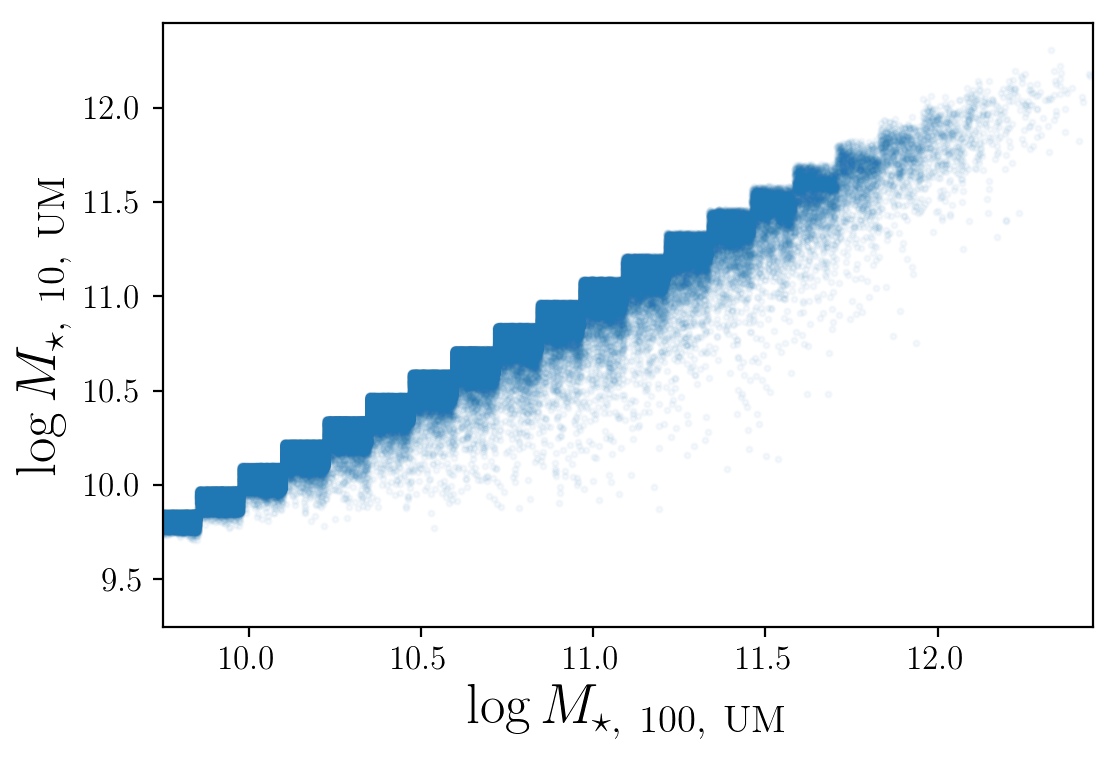

In [66]:
# Visualize the M100 v.s M10 plane
plt.scatter(log_m100_prof_model, log_m10_prof_model, 
            s=4, alpha=0.04);

plt.xlabel(r'$\log M_{\star,\ \mathrm{100,\ UM}}$', fontsize=20);
plt.ylabel(r'$\log M_{\star,\ \mathrm{10,\ UM}}$', fontsize=20);

plt.xlim(9.75, 12.45);
plt.ylim(9.25, 12.45);

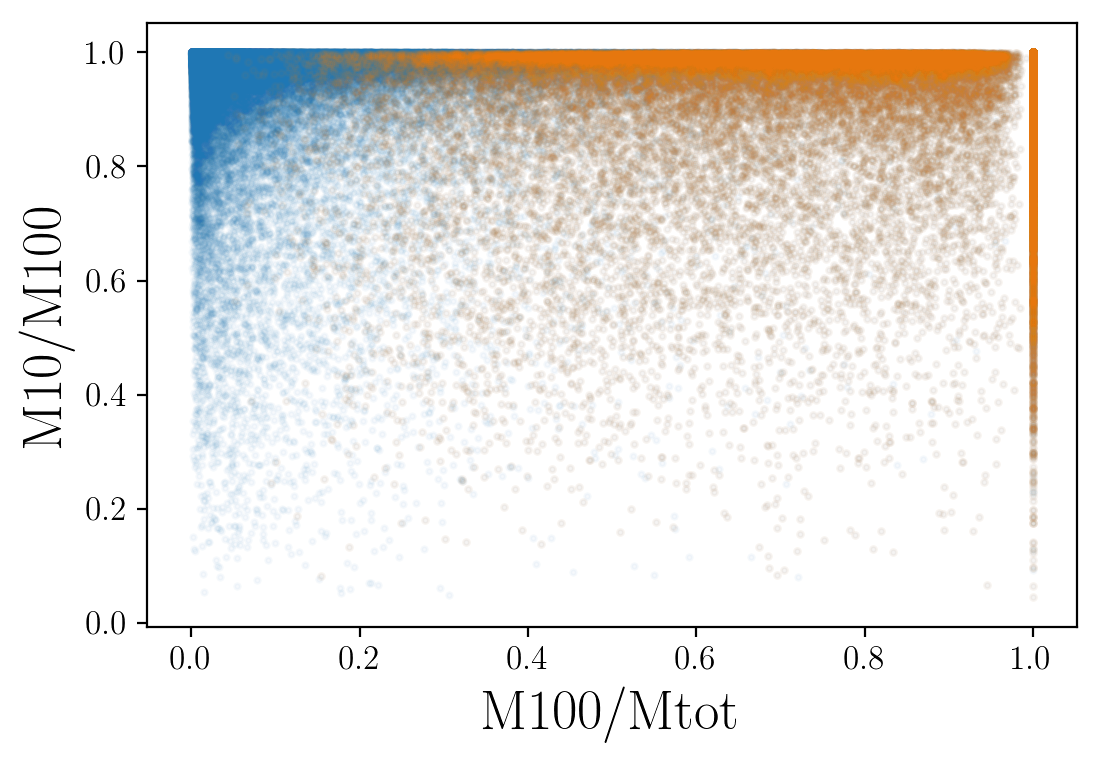

In [10]:
# Visualize the M100/Mtot v.s M10/M100 plane
plt.scatter(frac_sm100_by_smtot, frac_sm10_by_sm100, s=4, alpha=0.04);
plt.scatter(frac_sm100_by_smtot[mask_central], 
            frac_sm10_by_sm100[mask_central], s=5, alpha=0.04);

plt.xlabel('M100/Mtot', fontsize=20);
plt.ylabel('M10/M100', fontsize=20);

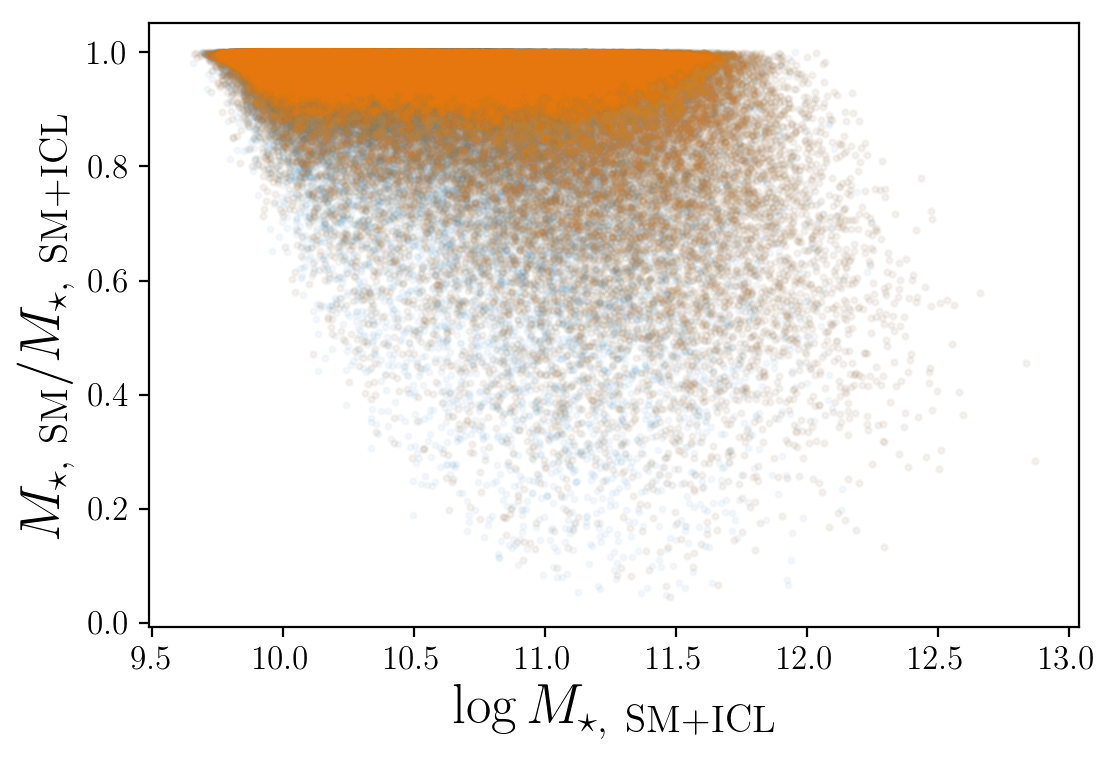

In [11]:
plt.scatter(log_m100_data, frac_sm10_by_sm100, s=4, alpha=0.04);
plt.scatter(log_m100_data[mask_central], 
            frac_sm10_by_sm100[mask_central], s=5, alpha=0.04);

plt.xlabel(r'$\log M_{\star,\ \mathrm{SM+ICL}}$', fontsize=20);
plt.ylabel(r'$M_{\star,\ \mathrm{SM}} / M_{\star,\ \mathrm{SM+ICL}}$', fontsize=20);

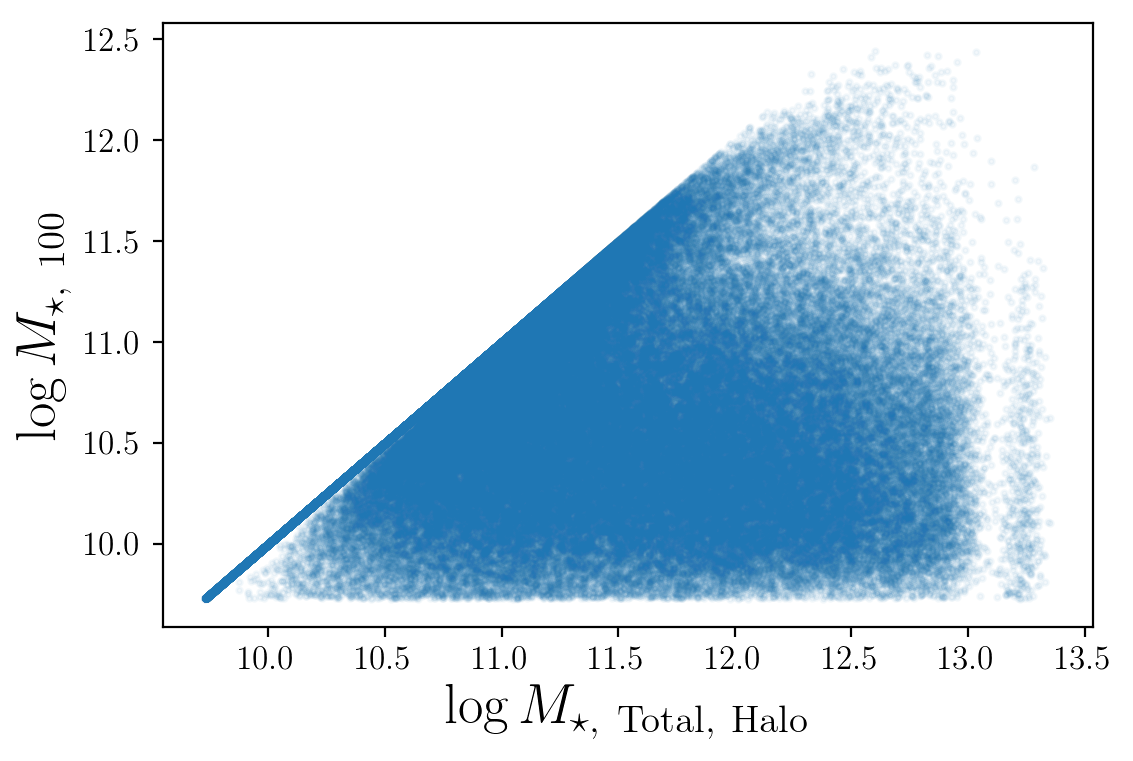

In [12]:
plt.scatter(log_mtot_prof_model[mask_m10_useful], 
            log_m100_prof_model[mask_m10_useful], 
            s=4, alpha=0.05);

plt.xlabel(r'$\log M_{\star,\ \mathrm{Total,\ Halo}}$', fontsize=20);
plt.ylabel(r'$\log M_{\star,\ \mathrm{100}}$', fontsize=20);

### Test: See the M10 v.s. M10/M100 (SecondHaloProp) relation in M100 bins

* Within each M100 bin, expect to see monotonic relation between M10 and secondHaloProp

(3003, 1933, 1079, 647, 354, 166)


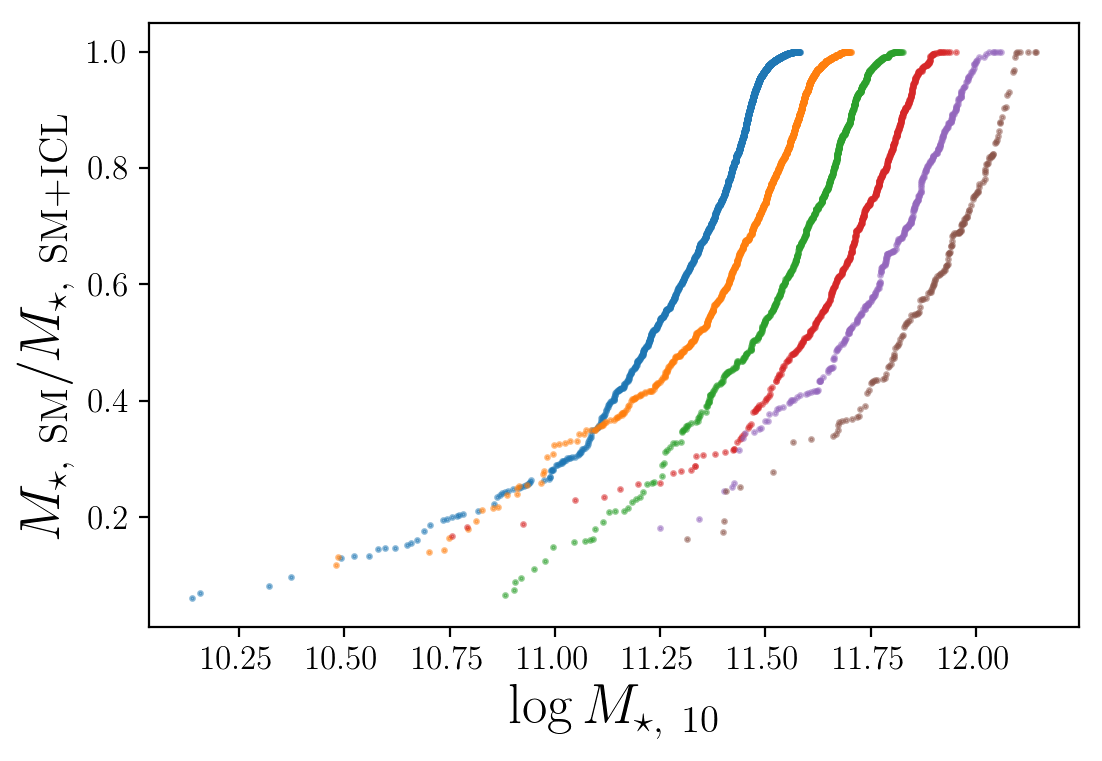

In [13]:
# Within a M100 bin, test the correlation between M10 and SecondHaloProp=frac_sm10_by_sm100
logm100 = log_m100_prof_model[mask_m10_useful]
logm10 = log_m10_prof_model[mask_m10_useful]

second_halo_prof = frac_sm10_by_sm100[mask_mass_cut]
second_halo_prof = second_halo_prof[mask_m10_useful]

assert len(logm100) == len(logm10) == len(second_halo_prof)

m100_bin1 = ((logm100 > log_m100_bins[14]) & (logm100 < log_m100_bins[15]))
m100_bin2 = ((logm100 > log_m100_bins[15]) & (logm100 < log_m100_bins[16]))
m100_bin3 = ((logm100 > log_m100_bins[16]) & (logm100 < log_m100_bins[17]))
m100_bin4 = ((logm100 > log_m100_bins[17]) & (logm100 < log_m100_bins[18]))
m100_bin5 = ((logm100 > log_m100_bins[18]) & (logm100 < log_m100_bins[19]))
m100_bin6 = ((logm100 > log_m100_bins[19]) & (logm100 < log_m100_bins[20]))

print(np.sum(m100_bin1), np.sum(m100_bin2), np.sum(m100_bin3),
      np.sum(m100_bin4), np.sum(m100_bin5), np.sum(m100_bin6))

plt.scatter(logm10[m100_bin1], second_halo_prof[m100_bin1], s=2, alpha=0.5);
plt.scatter(logm10[m100_bin2], second_halo_prof[m100_bin2], s=2, alpha=0.5);
plt.scatter(logm10[m100_bin3], second_halo_prof[m100_bin3], s=2, alpha=0.5);
plt.scatter(logm10[m100_bin4], second_halo_prof[m100_bin4], s=2, alpha=0.5);
plt.scatter(logm10[m100_bin5], second_halo_prof[m100_bin5], s=2, alpha=0.5);
plt.scatter(logm10[m100_bin6], second_halo_prof[m100_bin6], s=2, alpha=0.5);

plt.xlabel(r'$\log M_{\star,\ \mathrm{10}}$', fontsize=20);
plt.ylabel(r'$M_{\star,\ \mathrm{SM}} / M_{\star,\ \mathrm{SM+ICL}}$', fontsize=20);

### Test: Compare the UM Galaxy/Galaxy+ICL SMFs with the MassProfileModel M10/M100 SMFs

* Since we are using UM mass as "data", they should be very similar  

In [23]:
# Computs SMFs

## Compute Bolshoi SMF
bolshoi_volume= np.power(lbox / h, 3) # Mpc/h converted to real h values

bolshoi_ms, bolshoi_smf, bolshoi_err = compute_smf(mock['logms_gal'], 
                                                   bolshoi_volume, 
                                                   20, 10.0, 12.8)

bolshoi_ms_icl, bolshoi_smf_icl, bolshoi_err_icl = compute_smf(mock['logms_tot'], 
                                                               bolshoi_volume, 
                                                               20, 10.0, 12.8)

## Compute HSC SMF

# Read in the HSC data
hsc_m100_m10 = np.loadtxt('Data/s16a_massive_z0.3_0.5_m100_11.6_twoCols.txt')
logms_100_hsc = hsc_m100_m10[:,0]
logms_10_hsc = hsc_m100_m10[:,1]
logms_err_hsc = (logms_100_hsc * 0.0) + 0.08   # Assuming a constant error in Log

# HSC massive galaxy sample
zmin = 0.29
zmax = 0.51
# Based on Hiranao's calculation using Jean's new BrightStarMask
# Also applied full_depth_full_color_cut
hsc_area = 142.0 # deg^2

# Comoving Volume over a redshift interval per steradian (Mpc^3)
hsc_volume = ((cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)) * 
              (hsc_area / 41254.0))
hsc_volume = hsc_volume.value
print("# The volume of the HSC data is %15.2f Mpc^3" % hsc_volume)

#redshift_factor = (cosmo(zmax, /VOL)-cosmo(zmin, /VOL))
#boot_vol[i]  = redshift_factor*1.0*(boot_area[i]/41254.0)*4*!pi ; Mpc^-3

# Compare here
hsc_m10, hsc_m10_smf, hsc_m10_smf_err = compute_smf(logms_10_hsc, 
                                                    hsc_volume, 
                                                    15, 10.6, 11.8)

hsc_m100, hsc_m100_smf, hsc_m100_smf_err = compute_smf(logms_100_hsc, 
                                                       hsc_volume, 
                                                       12, 11.0, 12.2)

print("\r----------------------------------")
print(hsc_m100)
print(hsc_m100_smf)

# The volume of the HSC data is     79221830.77 Mpc^3
----------------------------------
[ 11.05  11.15  11.25  11.35  11.45  11.55  11.65  11.75  11.85  11.95
  12.05  12.15]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.20295125e-04   5.68025247e-05
   2.37308325e-05   7.06875863e-06   2.01964532e-06   2.52455665e-07]


In [54]:
hsc_m10_smf_boot = bootstrap_smf(logms_10_hsc, 
                                 logms_err_hsc, 
                                 hsc_volume, 
                                 12, 10.6, 11.8, 
                                 n_boots=5000)
hsc_m10, hsc_m10_smf, hsc_m10_smf_err, hsc_m10_smf_b = hsc_m10_smf_boot

hsc_m10_smf_med = np.nanmedian(hsc_m10_smf_b, axis=0)
hsc_m10_smf_low = np.nanpercentile(hsc_m10_smf_b, 16, axis=0,
                                   interpolation='midpoint')
hsc_m10_smf_upp = np.nanpercentile(hsc_m10_smf_b, 84, axis=0,
                                   interpolation='midpoint')
hsc_m10_smf_low -= (hsc_m10_smf_low * 0.10)
hsc_m10_smf_upp += (hsc_m10_smf_low * 0.10)

In [55]:
hsc_m100_smf_boot = bootstrap_smf(logms_100_hsc, 
                                  logms_err_hsc, 
                                  hsc_volume, 
                                  14, 11.0, 12.4, 
                                  n_boots=5000)
hsc_m100, hsc_m100_smf, hsc_m100_smf_err, hsc_m100_smf_b = hsc_m100_smf_boot

hsc_m100_smf_med = np.nanmedian(hsc_m100_smf_b, axis=0)
hsc_m100_smf_low = np.nanpercentile(hsc_m100_smf_b, 16, axis=0,
                                    interpolation='midpoint')
hsc_m100_smf_upp = np.nanpercentile(hsc_m100_smf_b, 84, axis=0,
                                    interpolation='midpoint')
hsc_m100_smf_low -= (hsc_m100_smf_low * 0.10)
hsc_m100_smf_upp += (hsc_m100_smf_low * 0.10)

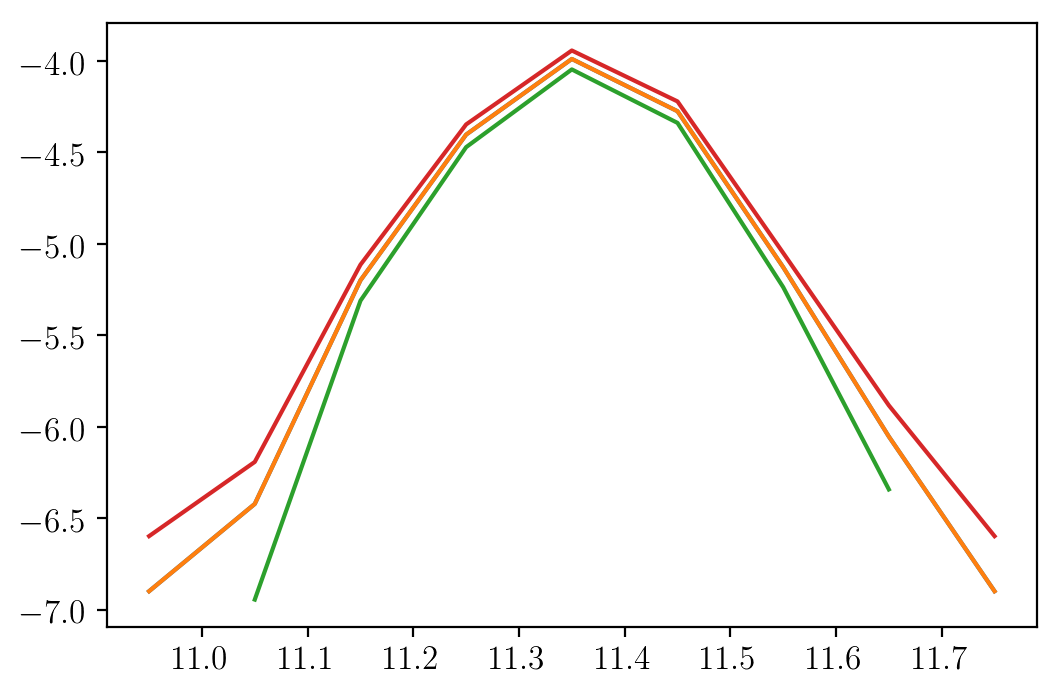

In [56]:
plt.plot(hsc_m10, np.log10(hsc_m10_smf));
plt.plot(hsc_m10, np.log10(hsc_m10_smf_med));
plt.plot(hsc_m10, np.log10(hsc_m10_smf_low));
plt.plot(hsc_m10, np.log10(hsc_m10_smf_upp));

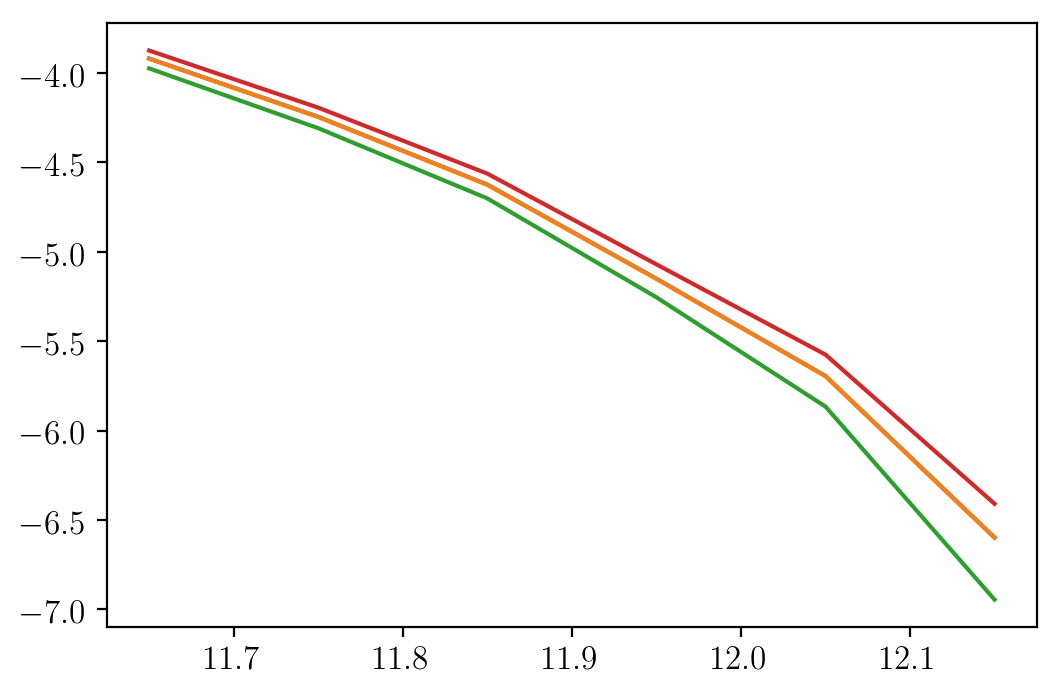

In [57]:
plt.plot(hsc_m100, np.log10(hsc_m100_smf));
plt.plot(hsc_m100, np.log10(hsc_m100_smf_med));
plt.plot(hsc_m100, np.log10(hsc_m100_smf_low));
plt.plot(hsc_m100, np.log10(hsc_m100_smf_upp));

In [58]:
# Computs SMFs from UM Mass Profile Models
## M10 
m10_um_prof_model = log_m10_prof_model[mask_m10_useful]
m100_um_prof_model = log_m100_prof_model[mask_m10_useful]

# Compute Bolshoi SMF
profmod_m10, profmod_m10_smf, profmod_m10_err = compute_smf(m10_um_prof_model, 
                                                            bolshoi_volume, 
                                                            20, 10.0, 12.4)

profmod_m100, profmod_m100_smf, profmod_m100_err = compute_smf(m100_um_prof_model, 
                                                               bolshoi_volume, 
                                                               20, 10.0, 12.4)

(9.91, 12.59)

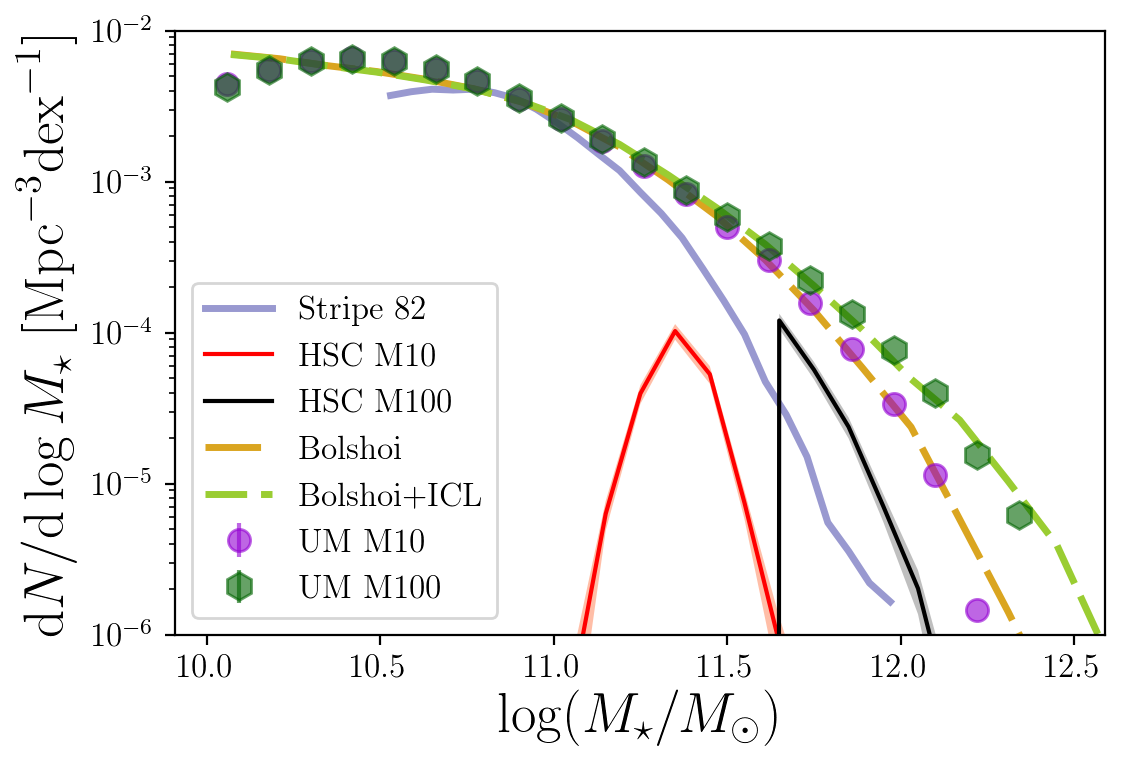

In [62]:
# Compare the SMF

# Read in Stripe 82 data
s82 = np.loadtxt('Data/s82_total_smf_0.15_0.43.txt')

fig, ax = plt.subplots(1,1)

#ax.ylim=(1e-6,1e-2)  # not working?
yscale = ax.set_yscale('log')
xlim = ax.set_xlim(xmin = 10.8, xmax=12.5)
ylim = ax.set_ylim(ymin = 1e-6, ymax=1e-2)
xlabel = ax.set_xlabel(r'$\log (M_{\star}/M_{\odot})$', fontsize=20)
ylabel = ax.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=20)

# SMF from S82-MGC; CModel + iSEDFit
#ax.errorbar(s82[:,0], s82[:,1], yerr=s82[:,2], fmt='.', marker='o', ms=4.0, 
#            color='darkblue', label='Stripe 82')
ax.plot(s82[:,0], s82[:,1], linestyle='-', linewidth=2.5, zorder=0, alpha=0.4, 
            color='darkblue', label='Stripe 82')

# SMF from HSC Massive; 10 kpc + iSEDFit
ax.fill_between(hsc_m10, hsc_m10_smf_low, hsc_m10_smf_upp, 
                facecolor='coral', edgecolor='none', alpha=0.5)
ax.plot(hsc_m10, hsc_m10_smf_med, c='red', label='HSC M10')

# SMF from HSC Massive; 100 kpc + iSEDFit
ax.fill_between(hsc_m100, hsc_m100_smf_low, hsc_m100_smf_upp,
                facecolor='gray', edgecolor='none', alpha=0.5)
ax.plot(hsc_m100, hsc_m100_smf_med, c='black', label='HSC M100')

# SMF from UniverseMachine
ax.plot(bolshoi_ms, bolshoi_smf, c='goldenrod', linewidth=2.5, linestyle='--',
        dashes=(8, 2), label='Bolshoi')

ax.plot(bolshoi_ms_icl, bolshoi_smf_icl, c='yellowgreen', linewidth=2.5, linestyle='--',
        dashes=(6, 2), label='Bolshoi+ICL')

# SMF from the UniverseMachine mass profile model
ax.errorbar(profmod_m10, profmod_m10_smf, yerr=profmod_m10_err, 
            fmt='.', marker='o', ms=8.0, alpha=0.6,
            color='darkviolet', label='UM M10')
ax.errorbar(profmod_m100, profmod_m100_smf, yerr=profmod_m100_err, 
            fmt='.', marker='h', ms=10.0, alpha=0.6,
            color='darkgreen', label='UM M100')

ax.legend(loc='lower left')

ax.set_xlim(9.91, 12.59)

# Lensing modeling using Halotools

In [4]:
halocat = CachedHaloCatalog(simname='multidark', redshift=0.0)

particles = halocat.ptcl_table
particle_masses = halocat.particle_mass

total_num_ptcl_in_snapshot = (halocat.num_ptcl_per_dim ** 3)
downsampling_factor = total_num_ptcl_in_snapshot / float(len(particles))

print("# The downsampling factor is: %11.6f" % downsampling_factor)

# The downsampling factor is: 8589.934592


In [82]:
print(halocat.fname)
print(halocat.halo_table.keys())
print(halocat.Lbox[0])

/Users/song/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5
['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_delta_vmax_behroozi17', 'halo_xoff', 'halo_spin', 'halo_tidal_force', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_tidal_id', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_tidal_force_tdyn', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'h

## Pre-compute the total amount of mass in cylinders surrounding each model galaxy

In [87]:
# Try without using any mass cut
sample = mock

# Radius bins
rp_bins = np.logspace(-1.0, 1.5, 20)
# Box size
period = halocat.Lbox[0]

start = time()
mass_encl = precompute_lensing_pairs(
    sample['x'], sample['y'], sample['z'], 
    particles['x'], particles['y'], particles['z'],
    particle_masses, downsampling_factor, 
    rp_bins, period)
end = time()
runtime = (end - start) 

num_sample = len(sample)
num_ptcl = len(particles)

msg = "Total runtime for {0} galaxies and {1:.1e} particles = {2:.2f} seconds"

print(msg.format(num_sample, num_ptcl, runtime))

Total runtime for 312923 galaxies and 1.0e+06 particles = 316.37 seconds


### Write to a binary file

In [102]:
precompute_shape = mass_encl.shape
precompute_mass_binary = "Data/bolplanck_rockstar_halotools_v0p4_z0.0_precompute"

In [103]:
np.savez(precompute_mass_binary, data=mass_encl)

### Read the precompute files

In [104]:
temp = np.load(precompute_mass_binary + '.npz')
mass_encl = temp['data']

## Example of WL signal from simulation

* Be careful with h
* For the new M100 and M10, need to trace them back to the mock catalog

# Deal with 2924 galaxies in the subsample


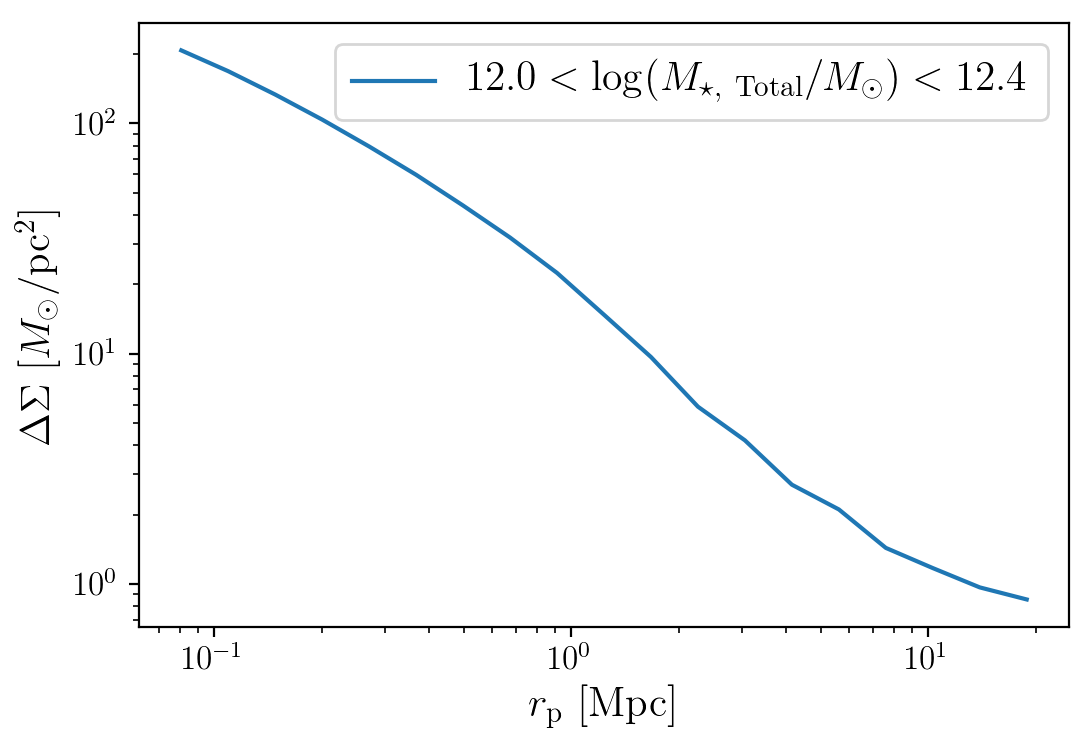

In [112]:
# Define a subsampe
mask = ((mock['logms_tot'] >= 11.65) & 
        (mock['logms_tot'] <= 12.50))
subsample = mock[mask]
print("# Deal with %d galaxies in the subsample" % np.sum(mask))

#  Use the mask to get subsample positions and pre-computed pairs
subsample_positions = np.vstack([subsample['x'], 
                                 subsample['y'], 
                                 subsample['z']]).T

subsample_mass_encl_precompute = mass_encl[mask, :]

rp_ht_units, ds_ht_units = delta_sigma_from_precomputed_pairs(
    subsample_positions, 
    subsample_mass_encl_precompute, 
    rp_bins, period, 
    cosmology=halocat.cosmology)

# Unit conversion
ds_phys_msun_pc2 = (1. + halocat.redshift) ** 2 * ds_ht_units / (1e12 * halocat.cosmology.h)
rp_phys = (rp_ht_units * halocat.cosmology.h) /(1. + halocat.redshift)


# Visualize the result
fig, ax = plt.subplots(1, 1)

ax.loglog()
ax.plot(rp_phys, ds_phys_msun_pc2, 
        label=r'$12.0<\log (M_{\star,\ \mathrm{Total}}/M_{\odot})<12.4$');

xlabel = ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}$', size=15);
ylabel = ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', size=15);

legend = ax.legend(fontsize=15, loc='upper right');

## Example of HSC lensing signal

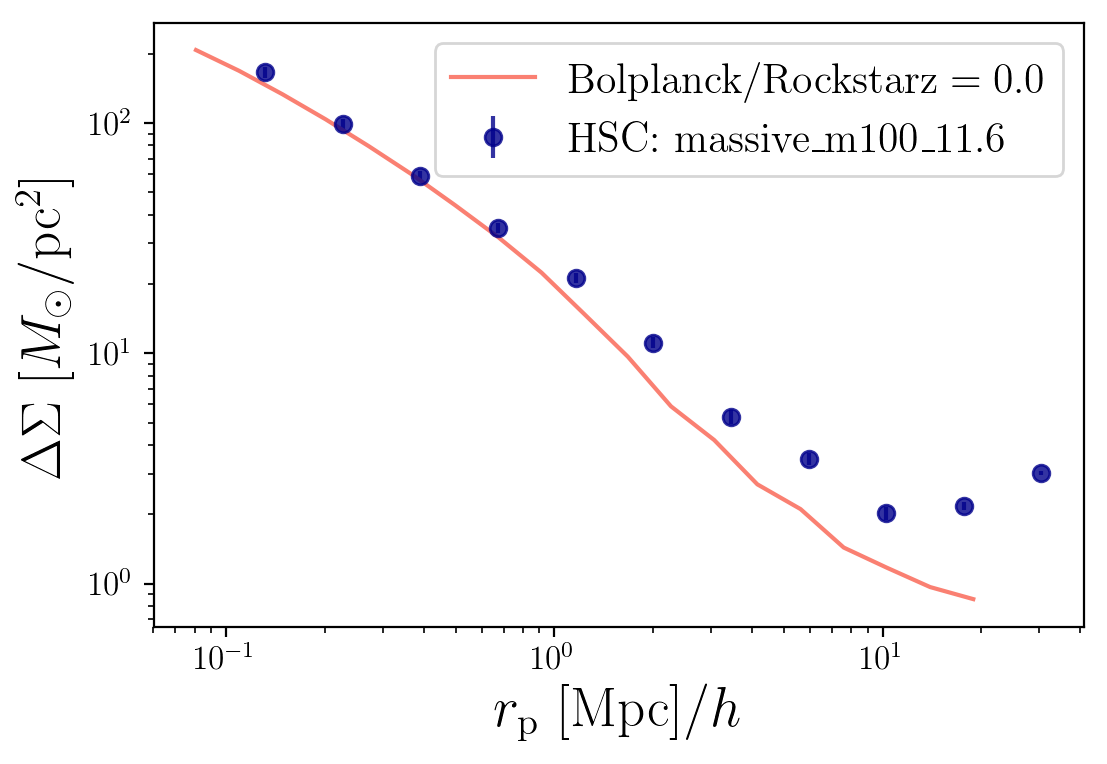

In [113]:
# !!!!! h values here !!!
# Compare with lensing here
dsarray = np.loadtxt('Data/s16a_massive_z0.3_0.5_m100_11.6.asc')

r = dsarray[:,0]
ds = dsarray[:,1]
ds_err = dsarray[:,2]


fig, ax = plt.subplots(1, 1)
ax.loglog()

ax.errorbar(r, ds, yerr=ds_err, fmt='.', marker='o', alpha=0.8,
            ms=6.0, color='darkblue', label=r'{\rm HSC: massive\_m100\_11.6}')

ax.plot(rp_phys, ds_phys_msun_pc2, linestyle='-', c='salmon', 
        label=r'${\rm Bolplanck/Rockstar z=0.0}$');

ax.set_xlabel(r'$r_{\rm p}$ ${\rm [Mpc]}/h$', size=20);
ax.set_ylabel(r'$\Delta\Sigma$ $[M_{\odot}/{\rm pc}^2]$', size=20);

legend = ax.legend(fontsize=15);

In [23]:
#download_initial_halocat.py
# from astropy.table import Table
# fname = '/Users/alexie/.astropy/cache/halotools/particle_catalogs/bolplanck/hlist_1.00231.particles.halotools_v0p4.hdf5'
# particles = Table.read(fname, path='data')

# particles['x'] # in Mpc/h

In [8]:
# Compute lensing from mock
#download_additional_halocat.py bolplanck rockstar halotools_v0p4 0

#Lbox = 100.0   # 100/h
#period = np.array([Lbox,Lbox,Lbox])

# Read in the Galaxy File
gal_list = np.loadtxt('/Users/alexie/Work/HSC/CompareHydroProfiles/DataFromMBII/mblack2_z0.3_m100_11.6_11.8.asc')
        
#        x=gal_list[:,2]
#        y=gal_list[:,3]
#        z=gal_list[:,4]
        
        # These are in units of kpc, put into Mpc
#        x=x/1000.0
#        y=y/1000.0
#        z=z/1000.0
                
        # Format the array for halotools
#        galpos = return_xyz_formatted_array(x, y, z)

        # Read in the DM file
#        dm_pos = np.fromfile('./position_data/dm/position',dtype=(np.float64,3))
        
        # Don't need this one for the DM, all the same mass
        #dm_mass = numpy.fromfile('./position_data/dm/mass',dtype=numpy.float64)

        # These are in units of kpc, put into Mpc
#        x=dm_pos[:,0]/1000.0
#        y=dm_pos[:,1]/1000.0
#        z=dm_pos[:,2]/1000.0
                
        # Format the array for halotools
#        dmpos = return_xyz_formatted_array(x, y, z)
        
#        ntotparticles = 5754585088.0
#        downsampling_factor = ntotparticles/10000000.0
#        print "downsampling factor"
#        print downsampling_factor

        #numpy.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None)[source]
        # This is in Mpc/h comoving
#        rp_bins = np.logspace(-1.5,1,10)
#        print 'Rp bins'
#        print rp_bins

        # We need an array with the particle masses
        # In our case, the particle masses are all the same
        # 8.723e+9 I think
        #particle_mass_array = x # sample lenth as position array
        # For the case when all the masses are constant, one can just use a single float which is the particle mass
#        particle_mass = 0.00110449e+10 
        
        # This is the new version of Delta Sigma
        # This is the new version of Delta Sigma
        #def delta_sigma(galaxies, particles, particle_masses, downsampling_factor,
        #rp_bins, period, cosmology=default_cosmology, num_threads=1,
        #approx_cell1_size=None, approx_cell2_size=None):
#        r, ds = delta_sigma(galpos, dmpos, particle_mass, downsampling_factor, rp_bins, Lbox)

        # units are in Msun / Mpc^2 ... divide by 1e12
#        ds = ds/1e12
        
#        table = {'rmpc': r,'deltasigma': ds}   
        
#        ascii.write(table, 'ds_dm_11.6_11.8.dat', formats={'rmpc': '%.5f', 'deltasigma': '%.5f'},Writer=ascii.CommentedHeader)
        #ascii.write(table

# Write down the model

In [ ]:
Free parameters:  
    1. smhm_a:  Slope of the log-log linear Mhalo-Ms_tot relation 
    2. smhm_b:  Normalization of the Mhalo-Ms_tot relation 
    3. sigmh_a: Slope of the log-log linear Mhalo-sig_Ms relation 
    4. sigmh_b: Normalization of the 